# CNN in health care to classify stage of an Alzheimer patient

In this study we are going to create a CNN model to determine the stage of a patient suffering from Alzheimer.   
The data set can be found from this kaggle : https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

The data consists of MRI images. The data has four classes of images both in training as well as a testing set:
- Mild Demented
- Moderate Demented
- Non Demented
- Very Mild Demented


## Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.__version__

'2.11.0'

## Exploring our dataset
We are using the pathlib library, this library allow us to define the path to the train set and test set   
We are going to plot informations for our dataset to explain some choices further in the study

In [3]:
# Define path to the data directory
data_dir = Path('Alzheimer_s Dataset')

# Path to train directory 
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'
print(train_dir)

Alzheimer_s Dataset\train


In [4]:
normal_cases_dir = train_dir / 'NonDemented'
moderate_cases_dir = train_dir / 'ModerateDemented'
mild_cases_dir = train_dir / 'MildDemented'
verymild_cases_dir = train_dir / 'VeryMildDemented'
# We define the directory for every stages of the disease 

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpg')
moderate_cases = moderate_cases_dir.glob('*.jpg')
mild_cases = mild_cases_dir.glob('*.jpg')
verymild_cases = verymild_cases_dir.glob('*.jpg')


train_data = []
# We create an empty list, we will use to set a label for each stage of the disease 

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the moderate demented cases. The label for these cases will be 1
for img in moderate_cases:
    train_data.append((img, 1))
    
# Go through all the mild demented cases. The label for these cases will be 2
for img in mild_cases:
    train_data.append((img, 2))
    
# Go through all the very mild demented cases. The label for these cases will be 3
for img in verymild_cases:
    train_data.append((img, 3))
    
    
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head(10)

,image,label
0,Alzheimer_s Dataset\train\MildDemented\mildDem...,2
1,Alzheimer_s Dataset\train\MildDemented\mildDem...,2
2,Alzheimer_s Dataset\train\VeryMildDemented\ver...,3
3,Alzheimer_s Dataset\train\MildDemented\mildDem...,2
4,Alzheimer_s Dataset\train\NonDemented\nonDem15...,0
5,Alzheimer_s Dataset\train\NonDemented\nonDem11...,0
6,Alzheimer_s Dataset\train\NonDemented\nonDem24...,0
7,Alzheimer_s Dataset\train\NonDemented\nonDem12...,0
8,Alzheimer_s Dataset\train\NonDemented\nonDem24...,0
9,Alzheimer_s Dataset\train\VeryMildDemented\ver...,3


0    2560
1      52
2     717
3    1792
Name: label, dtype: int64


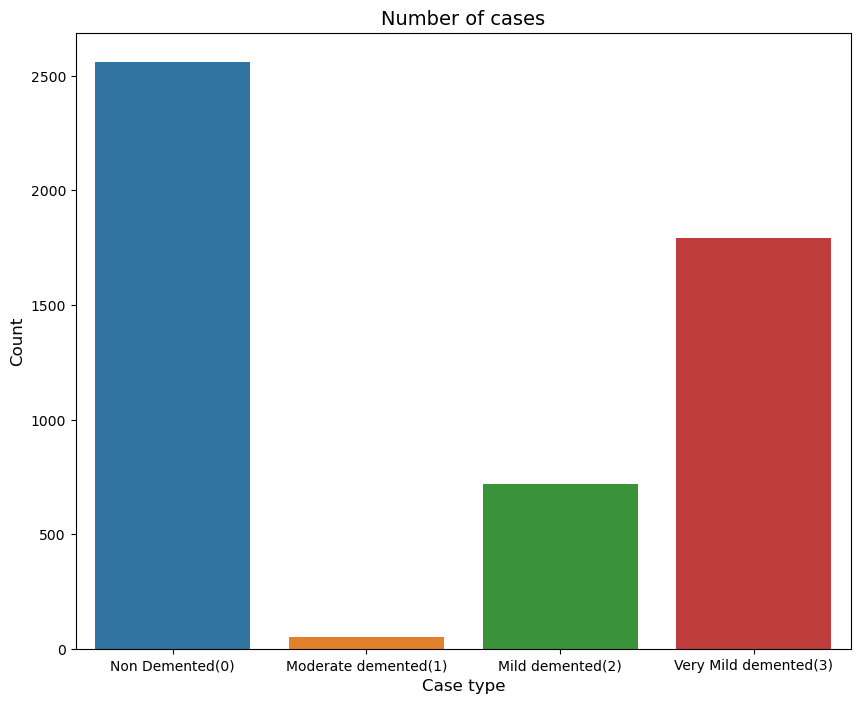

In [5]:
# Get the counts for each class and sort it by index

cases_count = train_data['label'].value_counts().sort_index()
print(cases_count)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Non Demented(0)', 'Moderate demented(1)', 'Mild demented(2)', 'Very Mild demented(3)'])
plt.show()



From this observation we can explain some choices for the analysis.  
From this plot we see that we have a inegal distribution of the values, in fact we have a lot of non demented patient in contrary moderate demented patient   
From this statement we will have to dome some choices in the continuation of the study   

## Visualizing the data  
in the following code we are just going to plot the MRI from very mild demented patient

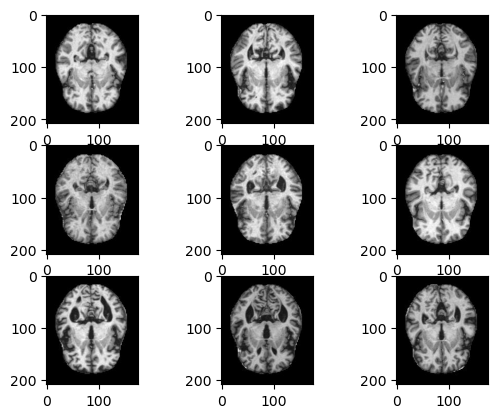

In [6]:
# we are going to plot a few elements from our train data
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset

folder = 'Alzheimer_s Dataset/train/VeryMildDemented/'
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # define filename
 filename = folder + 'verymildDem' + str(i) + '.jpg' 
 # load image pixels
 image = imread(filename)
 # plot raw pixel data
 pyplot.imshow(image,'gray')
# show the figure
pyplot.show()

## Preprocessing the data   
As explained before we have too little data for the moderate dem patient. In this case we are going to use ImageDataGenerator.   
This will allow us to generate batches of tensor image data with real-time data augmentation.  
Also because we are trying to predict what stage of the disease the patient is in so for training_set we are going to specify 'categorical' as the class mode of the flow_from_directory function

In [7]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale = 1./255,
        validation_split=0.2)

training_set = train_datagen.flow_from_directory('Alzheimer_s Dataset/train/', 
                                                 target_size=(64,64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = True,
                                                subset = 'training')




val_ds = train_datagen.flow_from_directory('Alzheimer_s Dataset/train/', 
                                                 target_size=(64,64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = True,
                                                subset = 'validation')


Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('Alzheimer_s Dataset/test/', 
                                                 target_size=(64,64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1279 images belonging to 4 classes.


## Creating the model  

In this part we will create the model :
Use classifierCNN to add the first convolutional layer.
We use filters and kernel size parameters to add (Convolution2D(...[params]...)), setting the number of filter detectors to 32 of size 3x3.
Due to the fact that we typically begin with 32 filter detectors and can use 64 in later layers   

Also, we must convert each of our photographs into the proper format.
We'll use the parameter input shape=[64, 64, 3] for our output image.
This indicates that since we have colorful images that are 64x64 pixels in size, we should expect three channels (we can use 256x256 if we have a GPU machine)   

Use the Rectifier activation function to remove the negative values and so end the non-linearity. We also use the dropout function to avoid an overfitting situation

In [9]:
from keras.models import Sequential
classifierCNN = Sequential()

In [10]:
from keras.layers import Convolution2D
classifierCNN.add(Convolution2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

In [11]:
from keras.layers import MaxPooling2D
classifierCNN.add(MaxPooling2D(pool_size=2, strides=2))

In [12]:
classifierCNN.add(Convolution2D(filters=32, kernel_size=3, activation='relu'))
classifierCNN.add(MaxPooling2D(pool_size=2, strides=2))

In [13]:
from keras.layers import Flatten
classifierCNN.add(Flatten())

In [14]:
from keras.layers import Dense
from keras.layers import Dropout
classifierCNN.add(Dense(units=128,activation='relu'))
classifierCNN.add(Dropout(0.1))

In [15]:
#We use the softmax activation function because we have a set of categorical variables as output

classifierCNN.add(Dense(units=4, activation='softmax'))
classifierCNN.add(Dropout(0.1))

classifierCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

In [16]:
classifierCNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['AUC'])

We use "metrics = ['AUC']" rather than "metrics = ['accuracy']" because our dataset has not an equal repartition, as we can observe at the graph.

In [17]:
classifierCNN.fit(x = training_set, validation_data = val_ds, epochs = 25)

Epoch 1/25
129/129 [==============================] - 18s 119ms/step - loss: 2.3831 - auc: 0.7313 - val_loss: 1.0301 - val_auc: 0.7969
Epoch 2/25
129/129 [==============================] - 12s 90ms/step - loss: nan - auc: 0.7494 - val_loss: 1.0131 - val_auc: 0.8022
Epoch 3/25
129/129 [==============================] - 12s 90ms/step - loss: 2.2797 - auc: 0.7624 - val_loss: 0.9687 - val_auc: 0.8271
Epoch 4/25
129/129 [==============================] - 12s 91ms/step - loss: 2.3708 - auc: 0.7688 - val_loss: 1.1969 - val_auc: 0.6395
Epoch 5/25
129/129 [==============================] - 12s 92ms/step - loss: nan - auc: 0.7623 - val_loss: 0.9949 - val_auc: 0.8263
Epoch 6/25
129/129 [==============================] - 13s 104ms/step - loss: nan - auc: 0.7691 - val_loss: 0.9907 - val_auc: 0.8272
Epoch 7/25
129/129 [==============================] - 13s 101ms/step - loss: nan - auc: 0.7774 - val_loss: 0.9500 - val_auc: 0.8343
Epoch 8/25
129/129 [==============================] - 12s 93ms/step - l

In [18]:
score = classifierCNN.evaluate(test_set)

40/40 [==============================] - 2s 48ms/step - loss: 0.9710 - auc: 0.8354


The AUC score is the area under this ROC curve, meaning that the resulting score represents in broad terms the model's ability to predict classes correctly. So in our case, because we obtain a AUC=0.8428 we know that our model accurately classify classes. 
We did not set a seed so it might chance from one computer to another